# Getting the data

Data file row

    0024  J020329.86-091020.3 666-52149-109   2000        3      Certain

## SDSS

Look up SDSS spectrum IDs by coordinates:

* http://skyserver.sdss.org/dr15/en/home.aspx
* go to navigate
* enter coordinates
* go to explore
* find FITS file URL

Get a single spectrum from SDSS

    $ wget https://dr15.sdss.org/sas/dr15/sdss/spectro/redux/26/spectra/lite/0666/spec-0666-52149-0109.fits
    $ wget http://dr15.sdss.org/sas/dr15/eboss/spectro/redux/v5_10_0/spectra/5743/spec-5743-56011-0077.fits
    
How to read the files

    http://classic.sdss.org/dr7/products/spectra/read_spSpec.html
    
What's in the files
    
    http://classic.sdss.org/dr7/products/spectra/
    
## Galex

To get a list of all files, use MAST SQL Search 

    http://galex.stsci.edu/GR6/?page=sqlform

with the following query

    SELECT fuv_filename, nuv_filename FROM SPECEXTRACT
    
Output is written to `data/galex_all.csv`, to extract tile names only, run

    $ cat galex_all.csv | cut -d',' -f 1 | grep -oP '[^/]+-[a-z]+-[a-z]+.fits' | grep -oP '^[^-]+' > galex_all.txt
    
Figure out the actual URL of the FITS file. Let's assume tile name is `GI3_104005_J020329m091020`

    $ cat galex_all.csv | grep GI3_104005_J020329m091020 | cut -d',' -f 1 | grep -oP '01-vsn[\w/-]+\.fits'
    
Replace `-gsax` with `-gsp` and the `-fg-` part with `-ng-` to get nuv part of spectrum.

Find spectra in Galex, specify Ra, Dec in sexagesimal format, e.g. 02:03:29.86, -09:10:20.3

    http://galex.stsci.edu/GR6/?page=tilelist&survey=spectra&showall=Y
    
Data format

    http://www.galex.caltech.edu/DATA/gr1_docs/GR1_Pipeline_and_advanced_data_description_v2.htm

Grab the fits file

    $ wget http://galex.stsci.edu/data/GR6/pipe/01-vsn/23663-GI3_104005_J020329m091020/g/01-main/0001-img/07-try/GI3_104005_J020329m091020-ng-gsp.fits.gz
    
    $ wget http://galex.stsci.edu/data/GR6/pipe/01-vsn/23663-GI3_104005_J020329m091020/g/01-main/0001-img/07-try/GI3_104005_J020329m091020-fg-gsp.fits.gz
    


In [2]:
%pylab inline

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

Populating the interactive namespace from numpy and matplotlib


In [3]:
!pwd

/mnt/local/data/astro/lls/py


## Coordinate conversion

In [4]:
c = SkyCoord.from_name('J100110.2+552834')
c

<SkyCoord (ICRS): (ra, dec) in deg
    (150.2926, 55.4762)>

## Get SDSS Spectrum from coordinate

Run the boxes below to get an authentication token for SDSS SkyServer. Use your SciServer/SkyServer/CasJobs account.

In [5]:
import getpass
from SciServer import Authentication, CasJobs

In [6]:
token = Authentication.login("dobos", getpass.getpass());

········


In [7]:
def run_sql(sql):
    df = CasJobs.executeQuery(sql=sql, context="DR15", format="pandas")
    return df

def find_sdss_spec(ra, dec):
    sql = """
SELECT specObjID, ra, dec, plate, mjd, fiberid
FROM SpecObj
WHERE ra BETWEEN %f AND %f AND dec BETWEEN %f AND %f
"""
    r = 2 / 3600  # search radius in degrees (i.e. 2 arc sec)
    df = run_sql(sql % (ra - r, ra + r, dec - r, dec + r))
    return df

In [8]:
find_sdss_spec(163.53443, 58.47528)

,specObjID,ra,dec,plate,mjd,fiberid
0,1068614841998010368,163.53445,58.475299,949,52427,494


# Load and plot an SDSS spectrum

Note, that these are sky-subtracted but not corrected for foreground extinction.

In [9]:
sdss = fits.open('../data/sdss/fits/spec-5743-56011-0077.fits')
spec = sdss[1]
info = sdss[2]

[2.0972316]


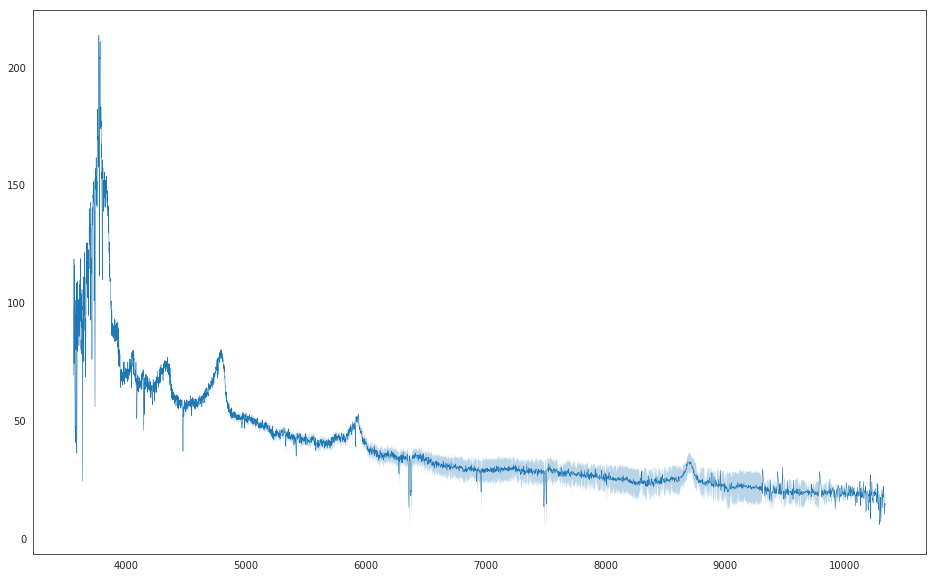

In [10]:
z = info.data['Z']
wl_sdss = 10**spec.data['loglam']
fl_sdss = spec.data['flux']
er_sdss = spec.data['ivar']

figsize(16, 10)
fill_between(wl_sdss, fl_sdss - 3 * er_sdss, fl_sdss + 3 * er_sdss, lw=0, alpha=0.3)
plot(wl_sdss, fl_sdss, lw=0.5)
print(z)

# Load and plot a Galex spectrum

In [11]:
#fuv = fits.open('../data/galex/fits/GI3_104005_J020329m091020-fg-gsp.fits.gz')
#nuv = fits.open('../data/galex/fits/GI3_104005_J020329m091020-ng-gsp.fits.gz')

#fuv = fits.open('../data/galex/fits/GI1_085032_NGC3079-fg-xsp.fits.gz')
#nuv = fits.open('../data/galex/fits/GI1_085032_NGC3079-ng-xsp.fits.gz')

fuv = fits.open('../data/galex/fits/GI1_033007_NGC3079-xg-gsp.fits.gz')

In [12]:
fuv[1].data.columns

ColDefs(
    name = 'ggoid'; format = '2J'; unit = 'number'
    name = 'ggoid_D'; format = '2J'; unit = 'number'
    name = 'band'; format = '1J'; unit = 'number'
    name = 'id'; format = '1J'; unit = 'number'
    name = 'alpha_j2000'; format = '1D'; unit = 'degrees'
    name = 'delta_j2000'; format = '1D'; unit = 'degrees'
    name = 'nuv_nc'; format = '1J'; unit = 'number'
    name = 'nuv_nr'; format = '1J'; unit = 'number'
    name = 'nuv_mag'; format = '1E'; unit = 'magnitude'
    name = 'nuv_detx'; format = '1E'; unit = 'pixel'
    name = 'nuv_dety'; format = '1E'; unit = 'pixel'
    name = 'nuv_Q'; format = '1E'; unit = 'value'
    name = 'nuv_mid_detx'; format = '1E'; unit = 'pixel'
    name = 'nuv_mid_dety'; format = '1E'; unit = 'pixel'
    name = 'nuv_mid_Q'; format = '1E'; unit = 'value'
    name = 'nuv_mid_ra'; format = '1D'; unit = 'degrees'
    name = 'nuv_mid_dec'; format = '1D'; unit = 'degrees'
    name = 'fuv_nc'; format = '1J'; unit = 'number'
    name = 'fuv_nr'; f

## Find closest object

In [13]:
print(c)
ra_all = fuv[1].data['alpha_j2000']
dec_all = fuv[1].data['delta_j2000']
idx = np.where(np.abs(ra_all - c.ra.value) < 1./3600.)
print(idx)
idx = idx[0][0]
ra = ra_all[idx]
dec = dec_all[idx]
print(ra, dec)

<SkyCoord (ICRS): (ra, dec) in deg
    (150.2926, 55.4762)>
(array([80]),)
150.2928237624488 55.47630947465953


# Figure out wavelength grid

In [14]:
print(fuv[1].data['zero'][idx])
print(fuv[1].data['disp'][idx])

1300.0
3.5


-999.0


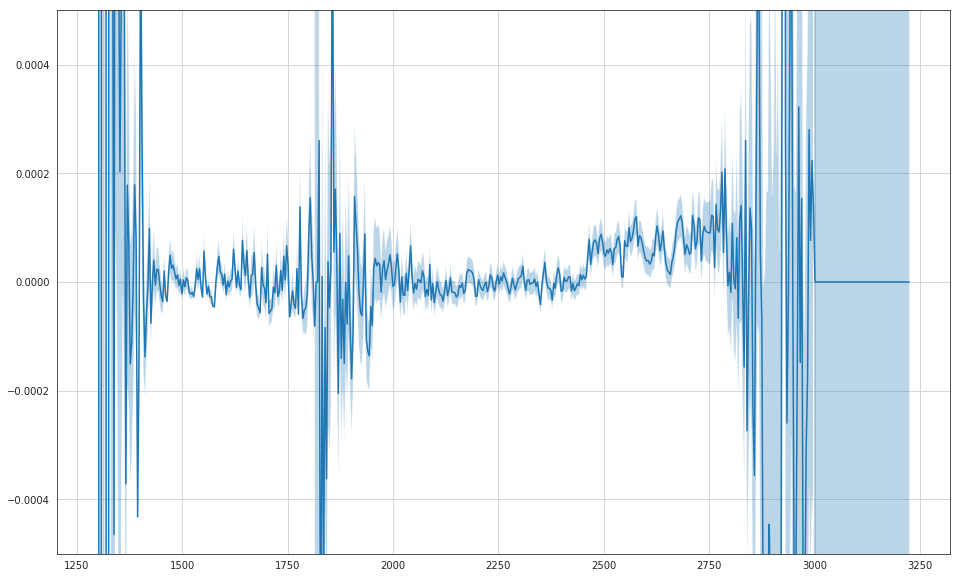

In [15]:
z = fuv[1].data['redshift'][idx]
fl_fuv = fuv[1].data['obj'][idx]
er_fuv = fuv[1].data['objerr'][idx]
wl_fuv = fuv[1].data['zero'][idx] + fuv[1].data['disp'][idx] * np.linspace(0, fl_fuv.shape[0] - 1, fl_fuv.shape[0])

#fl_nuv = nuv[1].data['obj'][idx]
#wl_nuv = nuv[1].data['zero'][idx] + nuv[1].data['disp'][idx] * np.linspace(0, fl_nuv.shape[0] - 1, fl_nuv.shape[0])

print(z)

figsize(16, 10)
grid(True)
ylim(-0.0005, 0.0005)
fill_between(wl_fuv, fl_fuv - er_fuv, fl_fuv + er_fuv, alpha=0.3)
plot(wl_fuv, fl_fuv)
#plot(wl_nuv, fl_nuv)

## Figure out flux unit conversion

Nice conversion chart:

    https://hea-www.harvard.edu/~pgreen/figs/Conversions.pdf


* SDSS is in $10^{-17}$ erg/sec/cm$^{2}$/A
* Galex is in photon/sec/cm$^{2}$/A

In [16]:
#fl_nuv_c = 1.99e-8 * 1e17 * fl_nuv / wl_nuv
fl_fuv_c = 1.99e-8 * 1e17 * fl_fuv / wl_fuv
er_fuv_c = 1.99e-8 * 1e17 * er_fuv / wl_fuv

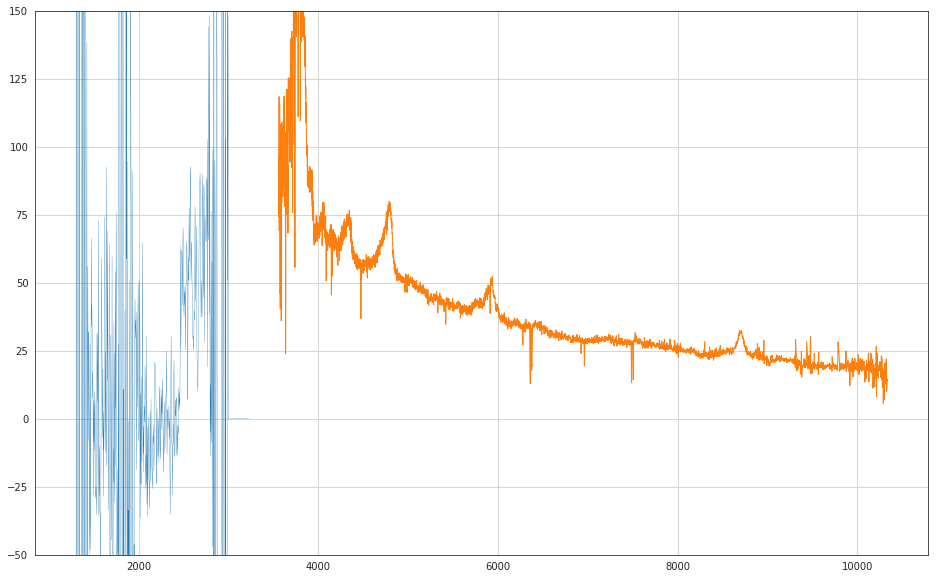

In [17]:
figsize(16, 10)
grid(True)
ylim(-50, 150)
plot(wl_fuv, fl_fuv_c, lw=0.3)
#plot(wl_nuv, fl_nuv_c, lw=0.3)
plot(wl_sdss, fl_sdss, lw=1)

## Plot absorption line markers over quasar spectrum

In [28]:
from linetools.lists.linelist import LineList
strong = LineList('Strong')

for n in strong.name:
    print(n, strong[n]['wrest'])

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
NeVI 401 401.14 Angstrom
NeII 405 405.8538 Angstrom
OII 418 418.598 Angstrom
OII 429 429.918 Angstrom
OII 430a 430.041 Angstrom
OII 430b 430.177 Angstrom
NeVI 433 433.176 Angstrom
NeII 446 446.2556 Angstrom
NeVII 465 465.221 Angstrom
NII 475 475.6481 Angstrom
NeIII 489 489.505 Angstrom
OIII 507 507.391 Angstrom
HeI 507 507.7178 Angstrom
HeI 508 508.6431 Angstrom
HeI 509 509.9979 Angstrom
HeI 515 515.6166 Angstrom
HeI 522 522.2128 Angstrom
NII 533 533.5099 Angstrom
HeI 537 537.0296 Angstrom
OII 539a 539.0855 Angstrom
OII 539b 539.5489 Angstrom
NeIV 541 541.127 Angstrom
NeIV 542 542.073 Angstrom
CII 543 543.257 Angstrom
NeIV 543 543.891 Angstrom
ArVI 551 551.3621 Angstrom
OIV 553 553.33 Angstrom
OIV 554 554.075 Angstrom
CaX 557 557.763 Angstrom
NeVI 558 558.59 Angstrom
CaX 574 574.01 Angstrom
CaVIII 582 582.845 Angstrom
HeI 584 584.334 Angstrom
OIV 608 608.398 Angstrom
MgX 609 609.79 An

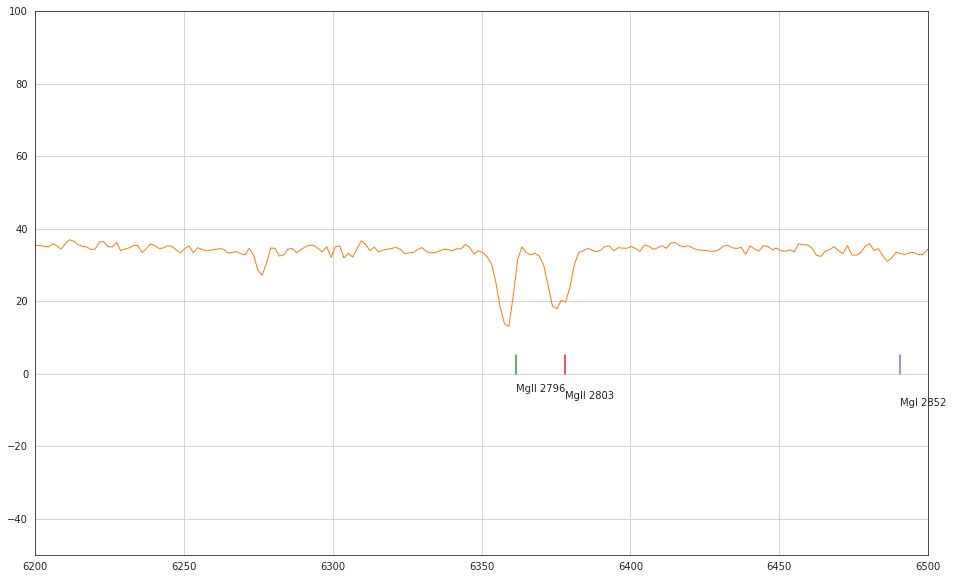

In [35]:
xmin = 6200
xmax = 6500
z = 1.275

figsize(16, 10)
grid(True)
ylim(-50, 100)
plot(wl_fuv, fl_fuv_c, lw=0.3)
#plot(wl_nuv, fl_nuv_c, lw=0.3)
plot(wl_sdss, fl_sdss, lw=1)
xlim(6200,6500)

i = 0
for n in strong.name:
    w = strong[n]['wrest'].value * (1 + z)
    if w > xmin and w < xmax:
        plot([w, w], [0, 5], '-')
        text(w, -5 - 2 * (i % 3), n)
        i += 1

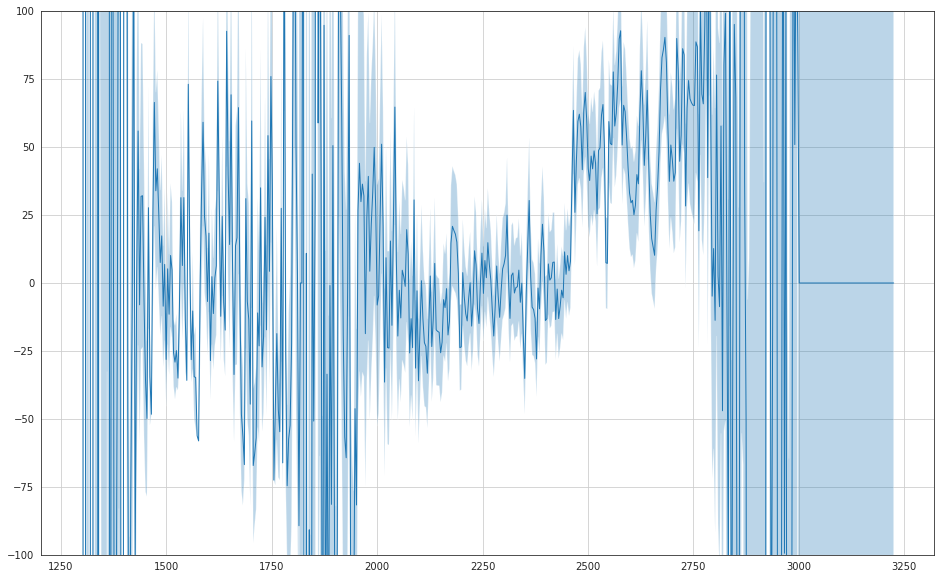

In [19]:
figsize(16, 10)
grid(True)
ylim(-100, 100)
fill_between(wl_fuv, fl_fuv_c - er_fuv_c, fl_fuv_c + er_fuv_c, alpha=0.3)
plot(wl_fuv, fl_fuv_c, lw=1)
#plot(wl_nuv, fl_nuv_c, lw=0.3)
#plot(wl_sdss, fl_sdss, lw=1)

# Testing necessary packages

Install packages directly from github

    # pip install git+https://github.com/linetools/linetools.git
    # pip install git+https://github.com/pyigm/pyigm.git


In [20]:
try:
    import seaborn as sns; sns.set_style("white")
except:
    pass

from linetools.spectra.xspectrum1d import XSpectrum1D
from pyigm.abssys import utils as igmau
from pyigm.abssys.lls import LLSSystem

In [21]:
# Compute the model in restframe
z =  1.678
lls = LLSSystem((0.*u.deg, 0.*u.deg), z, None, NHI=18.9)
lls

<LLSSystem: J000000+000000_z1.678000 00:00:00 +00:00:00, zabs=1.678, logNHI=18.9, tau_LL=50.3538, [Z/H]=0 dex>

In [22]:
%%capture --no-stdout --no-display
lls.fill_lls_lines()

read_sets: Using set file -- 
  /usr/local/miniconda3/envs/astro/lib/python3.6/site-packages/linetools/lists/sets/llist_v1.2.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [23]:
# create a wavelength grid from scratch
wave = np.arange(2000., 3000.)

# use the wavelength grid from galex
# but it should be redshifted!
# wave = wl_fuv

npix = len(wave)
spec = XSpectrum1D.from_tuple((wave*u.AA,np.ones(npix)))

In [19]:
%%capture --no-stdout --no-display
model = lls.flux_model(spec)

Let's try to find the redshift of the LLS by hand

(1900, 3000)

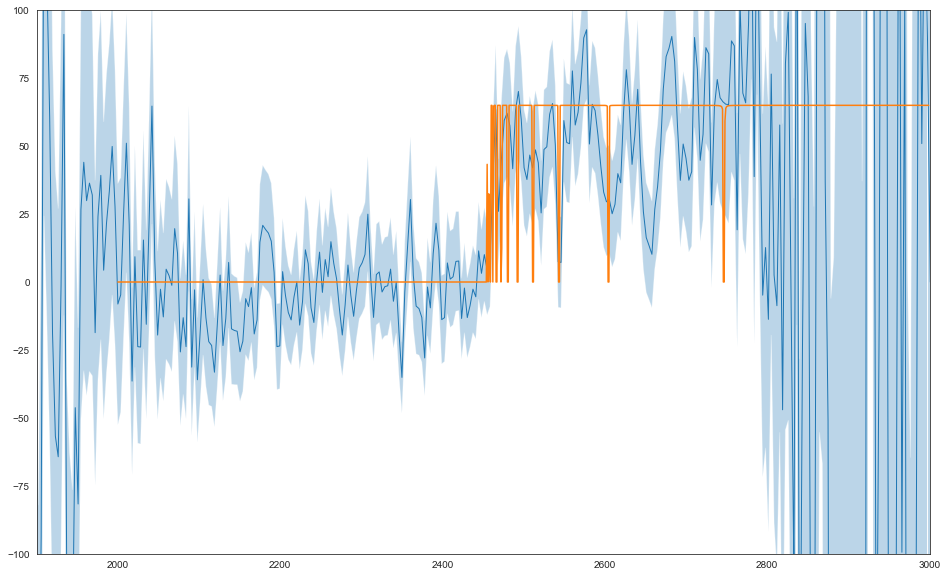

In [20]:
#model.plot()

fill_between(wl_fuv, fl_fuv_c - er_fuv_c, fl_fuv_c + er_fuv_c, alpha=0.3)
plot(wl_fuv, fl_fuv_c, lw=1)
plot(wave, model.flux * 65)
ylim(-100, 100)
xlim(1900, 3000)

# Try bayesian fitting with maximum a posteriori

In [21]:
import pymc
from pymc import MAP, MCMC, database, Matplot, graph

In [22]:
def create_lls(wl, z, c, NHI, v_disp):
    lls = LLSSystem((0.*u.deg, 0.*u.deg), float(z), None, NHI=NHI)
    lls.fill_lls_lines(bval=v_disp * u.km/u.s)
    spec = XSpectrum1D.from_tuple((wl * u.AA, np.ones(len(wl))))
    mdl = lls.flux_model(spec)
    return c * mdl.flux

def model(wl, fl, er):
    z = pymc.Uniform('z', 1.6, 1.7, value=1.65)
    c = pymc.Uniform('c', 10, 100, value=65)
    NHI = pymc.Uniform('NHI', 16, 19, value=17.9)    
    v_disp = pymc.Uniform('v_disp', 20, 400, value=200)
    
    @pymc.deterministic()
    def calc_lls(wl=wl, z=z, c=c, NHI=NHI, v_disp=v_disp):
        return create_lls(wl, z, c, NHI, v_disp)
    
    y = pymc.Normal('y', mu=calc_lls, tau=1/er**2, value=fl, observed=True)
    
    return locals()

In [24]:
mask = np.logical_and(wl_fuv > 200, wl_fuv < 2750)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


(1900, 3000)

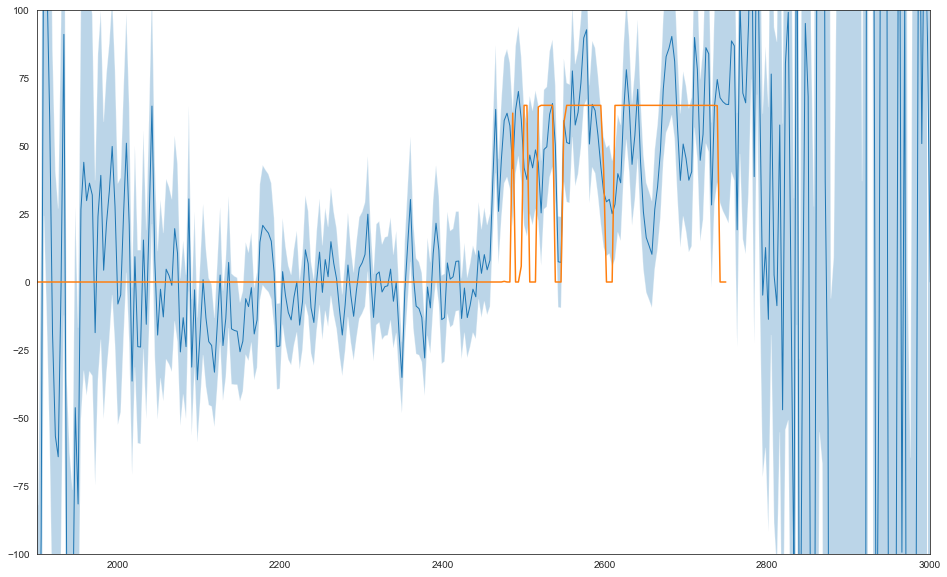

In [25]:
%%capture --no-stdout --no-display
fill_between(wl_fuv, fl_fuv_c - er_fuv_c, fl_fuv_c + er_fuv_c, alpha=0.3)
plot(wl_fuv, fl_fuv_c, lw=1)
plot(wl_fuv[mask], create_lls(wl_fuv[mask], 1.678, 65, 18.9, 200))
ylim(-100, 100)
xlim(1900, 3000)

In [26]:
%%capture --no-stdout --no-display

# Maximum aposteriori

M = pymc.MAP(model(wl_fuv[mask], fl_fuv_c[mask], er_fuv_c[mask]))
M.fit(iterlim=10)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on 

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on 

In [27]:
M.z.value, M.c.value, M.NHI.value, M.v_disp.value

(array(1.61792167),
 array(46.38074685),
 array(18.99998076),
 array(251.41082463))

In [28]:
%%capture --no-display
bestfit = create_lls(wl_fuv[mask], float(M.z.value), float(M.c.value), float(M.NHI.value), float(M.v_disp.value))

(1900, 3000)

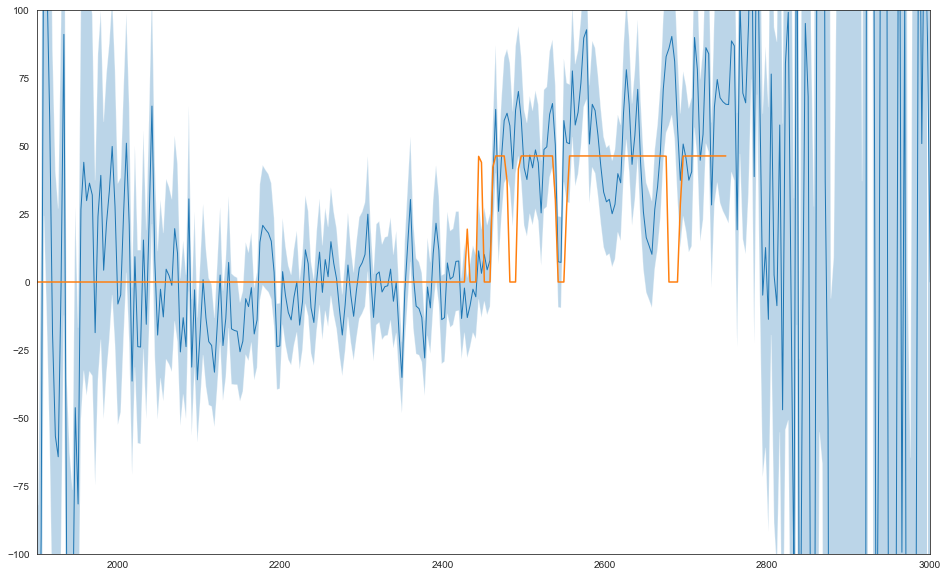

In [29]:
fill_between(wl_fuv, fl_fuv_c - er_fuv_c, fl_fuv_c + er_fuv_c, alpha=0.3)
plot(wl_fuv, fl_fuv_c, lw=1)
plot(wl_fuv[mask], bestfit)
ylim(-100, 100)
xlim(1900, 3000)

# Do the full MCMC

In [30]:
%%capture --no-display
M = MCMC(model(wl_fuv[mask], fl_fuv_c[mask], er_fuv_c[mask]))
M.sample(iter = 10000, burn = 500, thin = 10)

In [31]:
M.z.value, M.c.value, M.NHI.value, M.v_disp.value

(array(1.67935378), array(51.89507131), array(18.97104739), array(28.48429081))

In [32]:
mcmc_z = M.trace('z')[:]
mcmc_c = M.trace('c')[:]
mcmc_NHI = M.trace('NHI')[:]
mcmc_v_disp = M.trace('v_disp')[:]

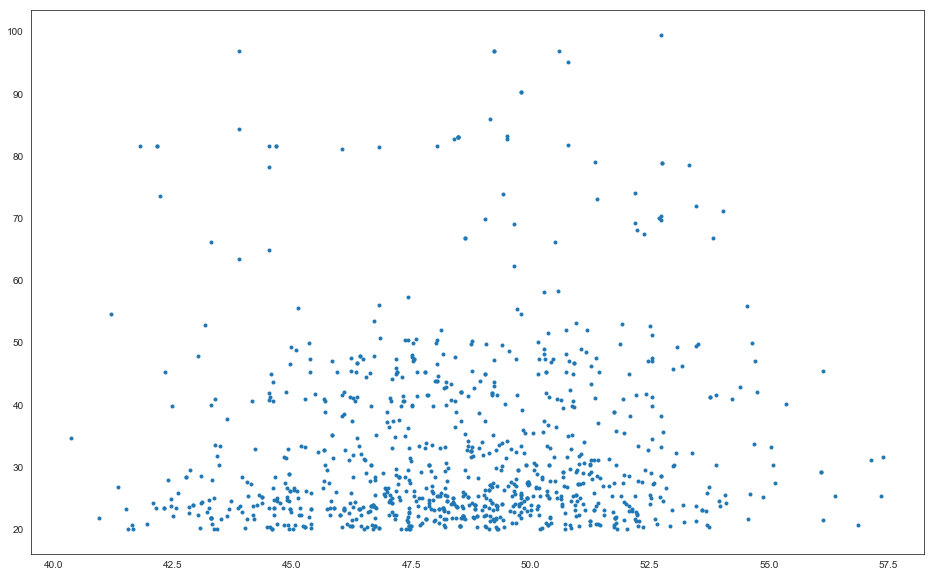

In [33]:
plot(mcmc_c, mcmc_v_disp, '.')

In [34]:
%%capture --no-display
bestfit = create_lls(wl_fuv[mask], np.mean(mcmc_z), np.mean(mcmc_c), np.mean(mcmc_NHI), np.mean(mcmc_v_disp))

(1900, 3000)

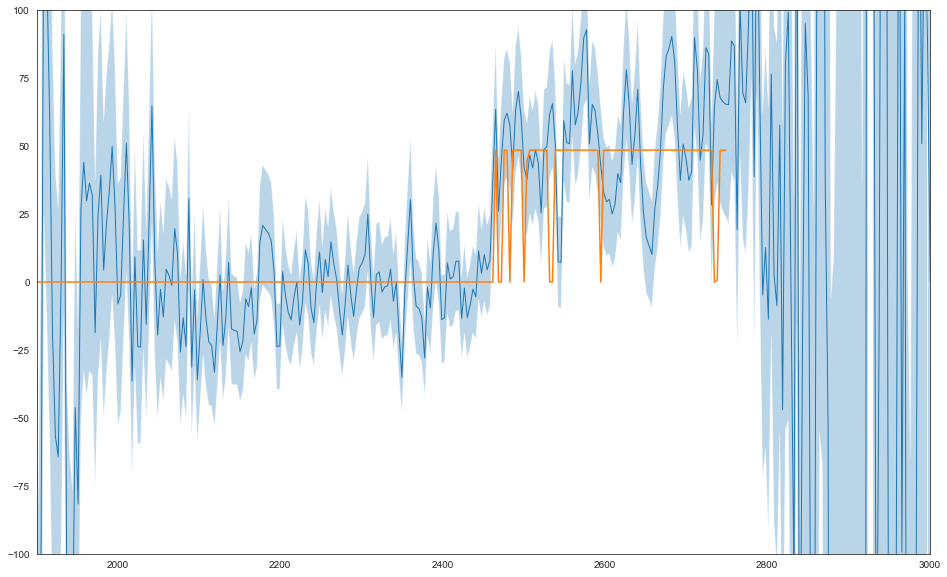

In [35]:
fill_between(wl_fuv, fl_fuv_c - er_fuv_c, fl_fuv_c + er_fuv_c, alpha=0.3)
plot(wl_fuv, fl_fuv_c, lw=1)
plot(wl_fuv[mask], bestfit)
ylim(-100, 100)
xlim(1900, 3000)